# PSNR과 SSIM 값 비교 분석

이 노트북은 다양한 모델들의 PSNR(Peak Signal-to-Noise Ratio)과 SSIM(Structural Similarity Index) 값을 비교 분석합니다.

## 분석 내용
1. 다양한 모델들의 가중치 로드
2. 노이즈 종류별 PSNR/SSIM 계산
3. SNR 레벨별 성능 비교
4. 시각화 및 결과 분석


In [15]:
# Part 1: 기본 설정 및 라이브러리 임포트
import os
import glob
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pandas as pd
from tensorflow.keras import layers, Model, regularizers
from sklearn.metrics import classification_report, confusion_matrix
from models.unet import build_unet_multitask as build_baseline_unet

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 한글 폰트가 없을 경우 대체 폰트 설정
try:
    # 시스템에 설치된 한글 폰트 찾기
    font_list = [f.name for f in fm.fontManager.ttflist]
    korean_fonts = [f for f in font_list if any(k in f.lower() for k in ['malgun', 'nanum', 'gulim', 'dotum', 'batang'])]
    
    if korean_fonts:
        plt.rcParams['font.family'] = korean_fonts[0]
        print(f"한글 폰트 설정: {korean_fonts[0]}")
    else:
        print("한글 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
except:
    print("폰트 설정 중 오류가 발생했습니다. 기본 폰트를 사용합니다.")

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


한글 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.
TensorFlow Version: 2.15.0
Num GPUs Available:  1


In [2]:
# Part 2: CIFAR-10 데이터 로드 및 전처리
print("--- CIFAR-10 데이터 로드 ---")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = y_train.flatten()
y_test = y_test.flatten()
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("CIFAR-10 data loaded.")

# 정규화 파라미터
MEAN = tf.constant(np.mean(x_train, axis=(0, 1, 2)), dtype=tf.float32)
STD = tf.constant(np.std(x_train, axis=(0, 1, 2)) + 1e-6, dtype=tf.float32)

def to_zscore(x):
    return (x - MEAN) / STD

def from_zscore(z):
    return z * STD + MEAN


--- CIFAR-10 데이터 로드 ---
CIFAR-10 data loaded.


2025-10-20 03:44:46.183371: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-20 03:44:46.183464: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-20 03:44:46.183482: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-20 03:44:46.295572: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-20 03:44:46.295627: I external/local_xla/xla/stream_executor

In [3]:
# Part 3: 노이즈 생성 함수들
def add_gaussian_noise_fixed_snr(clean_img_01, snr_db):
    """고정 SNR로 Gaussian 노이즈 추가"""
    img_z = to_zscore(clean_img_01)
    sigma = tf.pow(10.0, -snr_db/20.0)
    noise = tf.random.normal(tf.shape(img_z), stddev=sigma, dtype=tf.float32)
    noisy_z = img_z + noise
    cond = tf.convert_to_tensor([1.0, 0.0, 0.0, tf.clip_by_value((-snr_db/20.0 - 0.5), 0.0, 1.0)], dtype=tf.float32)
    return noisy_z, cond

def add_sp_noise_fixed_snr(clean_img_01, snr_db, amount=0.15):
    """고정 SNR로 Salt & Pepper 노이즈 추가"""
    img_z = to_zscore(clean_img_01)
    u = tf.random.uniform(tf.shape(img_z))
    salt = tf.cast(u < amount * 0.5, tf.float32)
    pepper = tf.cast(u > 1.0 - amount * 0.5, tf.float32)
    noisy_z = img_z * (1.0 - salt - pepper) + salt
    cond = tf.convert_to_tensor([0.0, 1.0, 0.0, amount], dtype=tf.float32)
    return noisy_z, cond

def add_burst_noise_fixed_snr(clean_img_01, snr_db, size_factor=0.3, intensity=0.85):
    """고정 SNR로 Burst 노이즈 추가"""
    img_z = to_zscore(clean_img_01)
    h, w, cch = tf.shape(img_z)[0], tf.shape(img_z)[1], tf.shape(img_z)[2]
    bh = tf.maximum(1, tf.cast(tf.cast(h, tf.float32) * size_factor, tf.int32))
    bw = tf.maximum(1, tf.cast(tf.cast(w, tf.float32) * size_factor, tf.int32))
    sy = tf.random.uniform([], maxval=tf.maximum(1, h - bh), dtype=tf.int32)
    sx = tf.random.uniform([], maxval=tf.maximum(1, w - bw), dtype=tf.int32)
    patch = tf.random.normal([bh, bw, cch], stddev=intensity)
    noise = tf.pad(patch, [[sy, h - sy - bh], [sx, w - sx - bw], [0, 0]])
    mask = tf.pad(tf.ones([bh, bw, cch]), [[sy, h - sy - bh], [sx, w - sx - bw], [0, 0]])
    noisy_z = img_z * (1.0 - mask) + (img_z + noise) * mask
    c = tf.clip_by_value(size_factor * intensity, 0.0, 1.0)
    cond = tf.convert_to_tensor([0.0, 0.0, 1.0, c], dtype=tf.float32)
    return noisy_z, cond


In [4]:
# Part 4: 모델 정의 함수들
def build_conditional_multitask_unet(input_shape_img, input_shape_map, num_classes):
    """조건부 멀티태스크 U-Net 모델"""
    def film_block(x, cond, channels):
        h = layers.Dense(2*channels, activation='relu')(cond)
        h = layers.Dense(2*channels)(h)
        gamma, beta = tf.split(h, 2, axis=-1)
        gamma = tf.reshape(gamma, (-1, 1, 1, channels))
        beta = tf.reshape(beta, (-1, 1, 1, channels))
        x = layers.BatchNormalization(center=False, scale=False)(x)
        return x * (1.0 + gamma) + beta

    def conv_block_cond(x, cond, nf):
        x = layers.Conv2D(nf, 3, padding='same', kernel_initializer='he_normal',
                          kernel_regularizer=regularizers.l2(1e-5))(x)
        x = layers.Activation('relu')(x)
        x = film_block(x, cond, nf)
        x = layers.Conv2D(nf, 3, padding='same', kernel_initializer='he_normal',
                          kernel_regularizer=regularizers.l2(1e-5))(x)
        x = layers.Activation('relu')(x)
        x = film_block(x, cond, nf)
        return x

    image_input = layers.Input(shape=input_shape_img, name="image_input")
    noise_map_input = layers.Input(shape=input_shape_map, name="noise_map_input")
    cond_in = noise_map_input

    # Encoder - 크기 추적
    c1 = conv_block_cond(image_input, cond_in, 32)  # 32x32, 32 channels
    p1 = layers.MaxPooling2D(2)(c1)  # 16x16, 32 channels
    
    c2 = conv_block_cond(p1, cond_in, 64)  # 16x16, 64 channels
    p2 = layers.MaxPooling2D(2)(c2)  # 8x8, 64 channels
    
    c3 = conv_block_cond(p2, cond_in, 128)  # 8x8, 128 channels
    p3 = layers.MaxPooling2D(2)(c3)  # 4x4, 128 channels
    
    b = conv_block_cond(p3, cond_in, 256)  # 4x4, 256 channels

    # Decoder - 올바른 크기 매칭
    d3 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(b)  # 4x4 -> 8x8, 128 channels
    d3 = layers.Concatenate()([d3, c3])  # 8x8, 256 channels (128+128)
    d3 = conv_block_cond(d3, cond_in, 128)  # 8x8, 128 channels

    d2 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(d3)  # 8x8 -> 16x16, 64 channels
    d2 = layers.Concatenate()([d2, c2])  # 16x16, 128 channels (64+64)
    d2 = conv_block_cond(d2, cond_in, 64)  # 16x16, 64 channels

    d1 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(d2)  # 16x16 -> 32x32, 32 channels
    d1 = layers.Concatenate()([d1, c1])  # 32x32, 64 channels (32+32)
    d1 = conv_block_cond(d1, cond_in, 32)  # 32x32, 32 channels

    residual_pred = layers.Conv2D(3, 1, activation='linear', name="residual_pred")(d1)
    restoration_head = layers.Subtract(name="restoration_output")([image_input, residual_pred])

    flat = layers.GlobalAveragePooling2D()(b)
    flat = layers.Concatenate()([flat, cond_in])
    dense1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(flat)
    dropout = layers.Dropout(0.5)(dense1)
    classification_head = layers.Dense(num_classes, activation='softmax', name="classification_output")(dropout)

    model = Model(inputs=[image_input, noise_map_input], outputs=[restoration_head, classification_head])
    return model


In [ ]:
# Part 5: 추가 모델 정의 (CAE, DnCNN)
# Baseline U-Net은 models/unet.py에서 import하여 사용
def build_cae_multitask(input_shape_img=(32,32,3), input_shape_map=(4,), num_classes=10):
    """CAE 멀티태스크 모델 - skip connection 없이 단순화"""
    img_in = layers.Input(shape=input_shape_img, name="image_input")
    cond_in = layers.Input(shape=input_shape_map, name="noise_map_input")

    # Encoder
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(img_in)  # 32x32x32
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)  # 32x32x32
    x = layers.MaxPooling2D(2)(x)  # 16x16x32
    
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)  # 16x16x64
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)  # 16x16x64
    x = layers.MaxPooling2D(2)(x)  # 8x8x64
    
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)  # 8x8x128
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)  # 8x8x128

    # Classification head
    feat = layers.GlobalAveragePooling2D()(x)
    cls_feat = layers.Concatenate()([feat, cond_in])
    cls_feat = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(cls_feat)
    cls_feat = layers.Dropout(0.5)(cls_feat)
    cls_out = layers.Dense(num_classes, activation='softmax', name='classification_output')(cls_feat)

    # Decoder for restoration - skip connection 제거
    d = layers.Conv2DTranspose(64, 2, strides=2, padding='same', activation='relu')(x)  # 8x8 -> 16x16x64
    d = layers.Conv2D(64, 3, padding='same', activation='relu')(d)  # 16x16x64
    d = layers.Conv2D(64, 3, padding='same', activation='relu')(d)  # 16x16x64
    
    d = layers.Conv2DTranspose(32, 2, strides=2, padding='same', activation='relu')(d)  # 16x16 -> 32x32x32
    d = layers.Conv2D(32, 3, padding='same', activation='relu')(d)  # 32x32x32
    d = layers.Conv2D(32, 3, padding='same', activation='relu')(d)  # 32x32x32
    rec = layers.Conv2D(3, 1, activation='linear', name='restoration_output')(d)  # 32x32x3

    return Model(inputs=[img_in, cond_in], outputs=[rec, cls_out], name='CAE_multitask')

def build_dncnn_multitask(input_shape_img=(32,32,3), input_shape_map=(4,), num_classes=10, depth=17, filters=64):
    """DnCNN 멀티태스크 모델"""
    img_in = layers.Input(shape=input_shape_img, name='image_input')
    cond_in = layers.Input(shape=input_shape_map, name='noise_map_input')

    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(img_in)
    for _ in range(depth-2):
        x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
    res = layers.Conv2D(3, 3, padding='same', activation='linear', name='residual_pred')(x)
    rec = layers.Subtract(name='restoration_output')([img_in, res])

    feat = layers.GlobalAveragePooling2D()(x)
    feat = layers.Concatenate()([feat, cond_in])
    feat = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(feat)
    feat = layers.Dropout(0.5)(feat)
    cls_out = layers.Dense(num_classes, activation='softmax', name='classification_output')(feat)

    return Model(inputs=[img_in, cond_in], outputs=[rec, cls_out], name='DnCNN_multitask')


In [ ]:
# Part 6: 모델 인스턴스 생성 및 가중치 로드
print("=== 모델 생성 및 가중치 로드 ===")

# 사용 가능한 모델 파일 확인
model_files = [f for f in os.listdir('.') if f.endswith('.keras')]
print("사용 가능한 모델 파일들:")
for f in model_files:
    print(f"  - {f}")

# 모델들 생성
num_classes = len(cifar10_class_names)

# MTL U-Net 모델 (조건부 멀티태스크)
mtl_unet_model = build_conditional_multitask_unet(
    input_shape_img=(32, 32, 3),
    input_shape_map=(4,),
    num_classes=num_classes
)
mtl_unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={'restoration_output': 'mean_absolute_error', 'classification_output': 'sparse_categorical_crossentropy'},
    loss_weights={'restoration_output': 0.8, 'classification_output': 0.2},
    metrics={'classification_output': 'accuracy'}
)

# Baseline U-Net 모델 (단일 입력)
baseline_unet_model = build_baseline_unet(
    input_shape_img=(32, 32, 3),
    num_classes=num_classes,
    base_filters=64,
    depth=3,
    residual=True
)
baseline_unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={'restoration_output': 'mean_absolute_error', 'classification_output': 'sparse_categorical_crossentropy'},
    loss_weights={'restoration_output': 0.8, 'classification_output': 0.2},
    metrics={'classification_output': 'accuracy'}
)

# CAE 모델
cae_model = build_cae_multitask(
    input_shape_img=(32, 32, 3),
    input_shape_map=(4,),
    num_classes=num_classes
)
cae_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={'restoration_output': 'mean_absolute_error', 'classification_output': 'sparse_categorical_crossentropy'},
    loss_weights={'restoration_output': 0.8, 'classification_output': 0.2},
    metrics={'classification_output': 'accuracy'}
)

# DnCNN 모델
dncnn_model = build_dncnn_multitask(
    input_shape_img=(32, 32, 3),
    input_shape_map=(4,),
    num_classes=num_classes
)
dncnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={'restoration_output': 'mean_absolute_error', 'classification_output': 'sparse_categorical_crossentropy'},
    loss_weights={'restoration_output': 0.8, 'classification_output': 0.2},
    metrics={'classification_output': 'accuracy'}
)

print("모델 생성 완료!")


=== 모델 생성 및 가중치 로드 ===
사용 가능한 모델 파일들:
  - best_unet_baseline.keras
  - best_dncnn_restoration_separate.keras
  - best_cae_restoration.keras
  - best_dncnn_multitask_mixed.keras
  - best_cae_restoration_separate.keras
  - best_cae_multitask_mixed.keras
  - best_classifier_separate.keras
  - best_cifar10_conditional_model.keras
  - best_dncnn_multitask.keras
  - best_cae_multitask.keras
  - best_unet_restoration.keras
  - best_unet_restoration_separate.keras
  - best_fixed_classifier.keras
  - best_dncnn_restoration.keras
모델 생성 완료!


In [7]:
# Part 7: 가중치 로드 (안전한 로드)
print("=== 가중치 로드 ===")

# MTL U-Net 가중치 로드
if 'best_cifar10_conditional_model.keras' in model_files:
    print("MTL U-Net 가중치 로드 시도 중...")
    try:
        mtl_unet_model.load_weights('best_cifar10_conditional_model.keras')
        print("MTL U-Net 가중치 로드 완료!")
    except Exception as e:
        print(f"MTL U-Net 가중치 로드 실패: {e}")
        print("MTL U-Net 모델은 랜덤 초기화된 상태로 사용됩니다.")
else:
    print("MTL U-Net 가중치 파일을 찾을 수 없습니다.")

# Baseline U-Net 가중치 로드
if 'best_unet_baseline.keras' in model_files:
    print("Baseline U-Net 가중치 로드 시도 중...")
    try:
        baseline_unet_model.load_weights('best_unet_baseline.keras')
        print("Baseline U-Net 가중치 로드 완료!")
    except Exception as e:
        print(f"Baseline U-Net 가중치 로드 실패: {e}")
        print("Baseline U-Net 모델은 랜덤 초기화된 상태로 사용됩니다.")
else:
    print("Baseline U-Net 가중치 파일을 찾을 수 없습니다.")

# CAE 가중치 로드
if 'best_cae_multitask.keras' in model_files:
    print("CAE 가중치 로드 시도 중...")
    try:
        cae_model.load_weights('best_cae_multitask.keras')
        print("CAE 가중치 로드 완료!")
    except Exception as e:
        print(f"CAE 가중치 로드 실패: {e}")
        print("CAE 모델은 랜덤 초기화된 상태로 사용됩니다.")
else:
    print("CAE 가중치 파일을 찾을 수 없습니다.")

# DnCNN 가중치 로드
if 'best_dncnn_multitask.keras' in model_files:
    print("DnCNN 가중치 로드 시도 중...")
    try:
        dncnn_model.load_weights('best_dncnn_multitask.keras')
        print("DnCNN 가중치 로드 완료!")
    except Exception as e:
        print(f"DnCNN 가중치 로드 실패: {e}")
        print("DnCNN 모델은 랜덤 초기화된 상태로 사용됩니다.")
else:
    print("DnCNN 가중치 파일을 찾을 수 없습니다.")

print("가중치 로드 완료!")


=== 가중치 로드 ===
MTL U-Net 가중치 로드 시도 중...


MTL U-Net 가중치 로드 완료!
Baseline U-Net 가중치 로드 시도 중...
Baseline U-Net 가중치 로드 실패: Cannot assign value to variable ' conv2d_14/kernel:0': Shape mismatch.The variable shape (3, 3, 3, 32), and the assigned value shape (3, 3, 3, 64) are incompatible.
Baseline U-Net 모델은 랜덤 초기화된 상태로 사용됩니다.
CAE 가중치 로드 시도 중...
CAE 가중치 로드 실패: Cannot assign value to variable ' conv2d_34/kernel:0': Shape mismatch.The variable shape (3, 3, 64, 64), and the assigned value shape (3, 3, 128, 64) are incompatible.
CAE 모델은 랜덤 초기화된 상태로 사용됩니다.
DnCNN 가중치 로드 시도 중...
DnCNN 가중치 로드 완료!
가중치 로드 완료!


In [ ]:
# Part 8: PSNR/SSIM 계산 함수
def calculate_psnr_ssim(model, test_images, test_labels, noise_type='gaussian', snr_levels=[-30, -25, -20, -15, -10], batch_size=128, is_baseline_unet=False):
    """
    모델의 PSNR과 SSIM을 계산하는 함수
    is_baseline_unet: True면 단일 입력 모델, False면 이중 입력 모델
    """
    results = {}
    
    for snr_db in snr_levels:
        print(f"SNR {snr_db} dB 처리 중...")
        
        # 고정 SNR로 데이터셋 생성
        if noise_type == 'gaussian':
            test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
            def _map_fn(clean_img, label):
                clean_img = tf.cast(clean_img, tf.float32)
                noisy_z, cond = add_gaussian_noise_fixed_snr(clean_img, tf.cast(snr_db, tf.float32))
                clean_z = to_zscore(clean_img)
                if is_baseline_unet:
                    # Baseline U-Net은 단일 입력 (노이즈가 추가된 이미지만)
                    return noisy_z, (clean_z, label)
                else:
                    # MTL 모델들은 이중 입력 (노이즈 이미지 + 조건)
                    return (noisy_z, cond), (clean_z, label)
            test_ds = test_ds.map(_map_fn, num_parallel_calls=tf.data.AUTOTUNE)
            test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        elif noise_type == 'sp':
            test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
            def _map_fn(clean_img, label):
                clean_img = tf.cast(clean_img, tf.float32)
                noisy_z, cond = add_sp_noise_fixed_snr(clean_img, tf.cast(snr_db, tf.float32))
                clean_z = to_zscore(clean_img)
                if is_baseline_unet:
                    return noisy_z, (clean_z, label)
                else:
                    return (noisy_z, cond), (clean_z, label)
            test_ds = test_ds.map(_map_fn, num_parallel_calls=tf.data.AUTOTUNE)
            test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        elif noise_type == 'burst':
            test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
            def _map_fn(clean_img, label):
                clean_img = tf.cast(clean_img, tf.float32)
                noisy_z, cond = add_burst_noise_fixed_snr(clean_img, tf.cast(snr_db, tf.float32))
                clean_z = to_zscore(clean_img)
                if is_baseline_unet:
                    return noisy_z, (clean_z, label)
                else:
                    return (noisy_z, cond), (clean_z, label)
            test_ds = test_ds.map(_map_fn, num_parallel_calls=tf.data.AUTOTUNE)
            test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        
        # PSNR/SSIM 계산
        psnr_values = []
        ssim_values = []
        
        for batch_data in test_ds:
            if is_baseline_unet:
                # Baseline U-Net: 단일 입력
                noisy_z_b, (clean_z_b, label_b) = batch_data
                pred_restored_b, _ = model.predict(noisy_z_b, verbose=0)
            else:
                # MTL 모델들: 이중 입력
                (noisy_z_b, cond_b), (clean_z_b, label_b) = batch_data
                pred_restored_b, _ = model.predict([noisy_z_b, cond_b], verbose=0)
            
            # 역정규화
            clean_b = tf.clip_by_value(from_zscore(clean_z_b), 0.0, 1.0).numpy()
            restored_b = tf.clip_by_value(from_zscore(pred_restored_b), 0.0, 1.0).numpy()
            
            # PSNR/SSIM 계산
            for i in range(restored_b.shape[0]):
                psnr = tf.image.psnr(restored_b[i:i+1], clean_b[i:i+1], max_val=1.0).numpy()[0]
                ssim = tf.image.ssim(restored_b[i:i+1], clean_b[i:i+1], max_val=1.0).numpy()[0]
                psnr_values.append(psnr)
                ssim_values.append(ssim)
        
        results[snr_db] = {
            'psnr_mean': np.mean(psnr_values),
            'psnr_std': np.std(psnr_values),
            'ssim_mean': np.mean(ssim_values),
            'ssim_std': np.std(ssim_values)
        }
    
    return results

print("PSNR/SSIM 계산 함수 정의 완료!")


PSNR/SSIM 계산 함수 정의 완료!


In [ ]:
# Part 9: 모델별 성능 평가
print("=== 모델별 성능 평가 ===")

# 테스트 데이터 샘플 (전체 데이터셋의 일부 사용)
test_sample_size = 1000
test_indices = np.random.choice(len(x_test), test_sample_size, replace=False)
test_sample_images = x_test[test_indices]
test_sample_labels = y_test[test_indices]

print(f"테스트 샘플 수: {test_sample_size}")

# SNR 레벨 정의
snr_levels = [-30, -25, -20, -15, -10]
noise_types = ['gaussian', 'sp', 'burst']

# 결과 저장용 딕셔너리
all_results = {}

# 각 모델별로 평가
models = {
    'MTL U-Net': mtl_unet_model,
    'Baseline U-Net': baseline_unet_model,
    'CAE': cae_model,
    'DnCNN': dncnn_model
}

for model_name, model in models.items():
    print(f"\n{model_name} 모델 평가 중...")
    model_results = {}
    
    # Baseline U-Net은 단일 입력 모델
    is_baseline = (model_name == 'Baseline U-Net')
    
    for noise_type in noise_types:
        print(f"  {noise_type} 노이즈 처리 중...")
        noise_results = calculate_psnr_ssim(
            model, test_sample_images, test_sample_labels, 
            noise_type=noise_type, snr_levels=snr_levels, batch_size=128,
            is_baseline_unet=is_baseline
        )
        model_results[noise_type] = noise_results
    
    all_results[model_name] = model_results

print("\n모든 모델 평가 완료!")


=== 모델별 성능 평가 ===
테스트 샘플 수: 1000

MTL U-Net 모델 평가 중...
  gaussian 노이즈 처리 중...
SNR -30 dB 처리 중...


2025-10-20 03:44:51.385777: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8905


SNR -25 dB 처리 중...
SNR -20 dB 처리 중...
SNR -15 dB 처리 중...
SNR -10 dB 처리 중...
  sp 노이즈 처리 중...
SNR -30 dB 처리 중...
SNR -25 dB 처리 중...
SNR -20 dB 처리 중...
SNR -15 dB 처리 중...
SNR -10 dB 처리 중...
  burst 노이즈 처리 중...
SNR -30 dB 처리 중...
SNR -25 dB 처리 중...
SNR -20 dB 처리 중...
SNR -15 dB 처리 중...
SNR -10 dB 처리 중...

Baseline U-Net 모델 평가 중...
  gaussian 노이즈 처리 중...
SNR -30 dB 처리 중...
SNR -25 dB 처리 중...
SNR -20 dB 처리 중...
SNR -15 dB 처리 중...
SNR -10 dB 처리 중...
  sp 노이즈 처리 중...
SNR -30 dB 처리 중...
SNR -25 dB 처리 중...
SNR -20 dB 처리 중...
SNR -15 dB 처리 중...
SNR -10 dB 처리 중...
  burst 노이즈 처리 중...
SNR -30 dB 처리 중...
SNR -25 dB 처리 중...
SNR -20 dB 처리 중...
SNR -15 dB 처리 중...
SNR -10 dB 처리 중...

CAE 모델 평가 중...
  gaussian 노이즈 처리 중...
SNR -30 dB 처리 중...
SNR -25 dB 처리 중...
SNR -20 dB 처리 중...
SNR -15 dB 처리 중...
SNR -10 dB 처리 중...
  sp 노이즈 처리 중...
SNR -30 dB 처리 중...
SNR -25 dB 처리 중...
SNR -20 dB 처리 중...
SNR -15 dB 처리 중...
SNR -10 dB 처리 중...
  burst 노이즈 처리 중...
SNR -30 dB 처리 중...
SNR -25 dB 처리 중...
SNR -20 dB 처리 중...
SN

=== 결과 시각화 ===


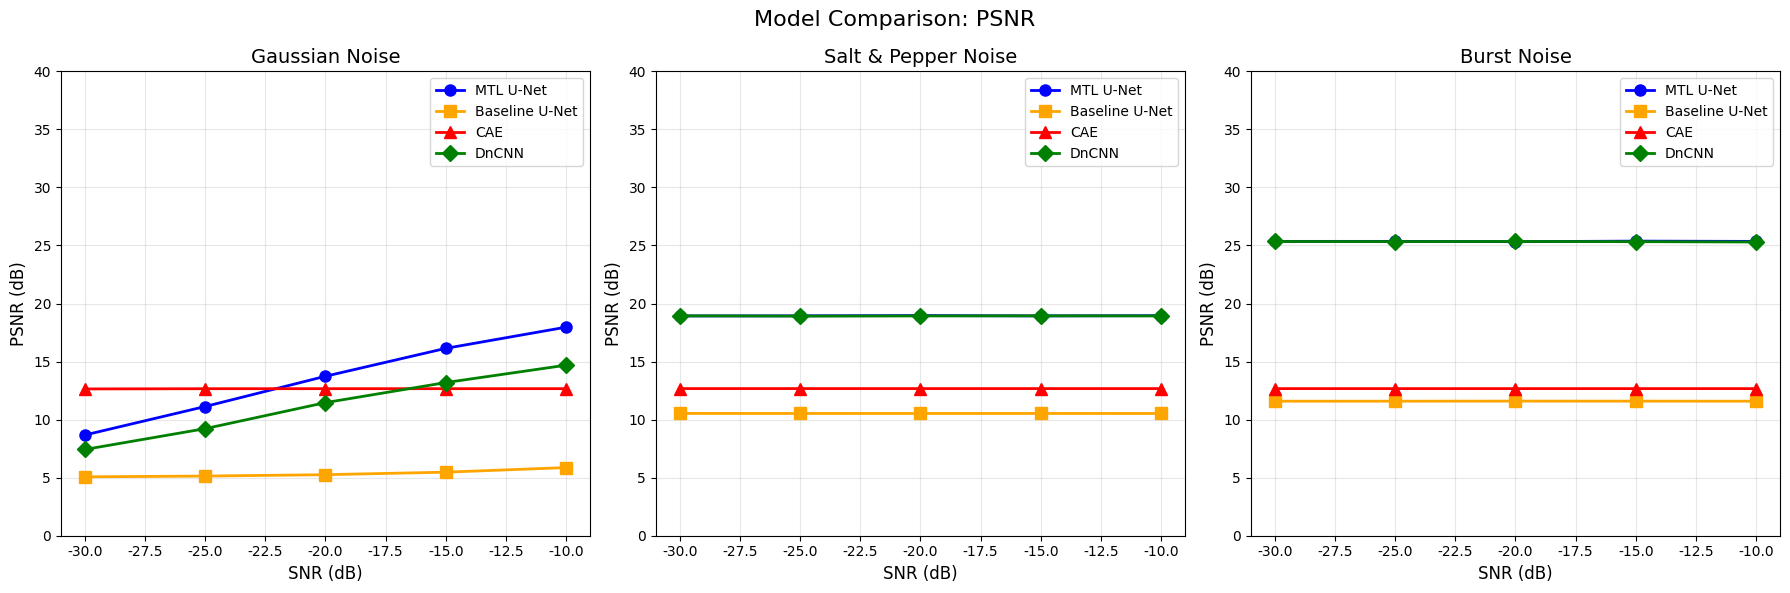

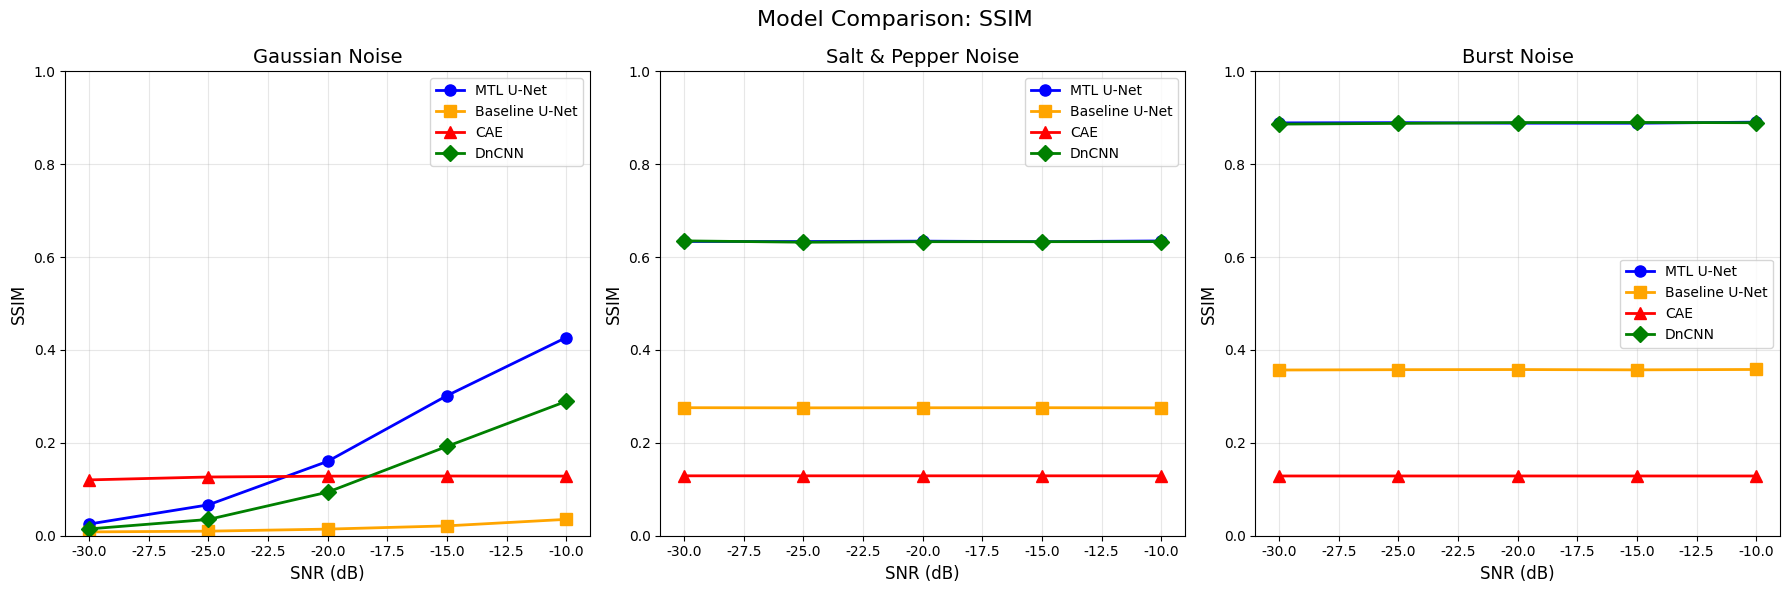

In [16]:
# Part 10: 결과 시각화
print("=== 결과 시각화 ===")

def plot_psnr_comparison(all_results, snr_levels):
    """PSNR 비교 플롯"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    noise_type_names = {'gaussian': 'Gaussian', 'sp': 'Salt & Pepper', 'burst': 'Burst'}
    colors = ['blue', 'orange', 'red', 'green']
    markers = ['o', 's', '^', 'D']
    
    for idx, noise_type in enumerate(['gaussian', 'sp', 'burst']):
        ax = axes[idx]
        
        for i, (model_name, model_results) in enumerate(all_results.items()):
            snrs = []
            psnrs = []
            psnr_stds = []
            
            for snr in snr_levels:
                if snr in model_results[noise_type]:
                    snrs.append(snr)
                    psnrs.append(model_results[noise_type][snr]['psnr_mean'])
                    psnr_stds.append(model_results[noise_type][snr]['psnr_std'])
            
            ax.plot(snrs, psnrs, 
                   marker=markers[i], color=colors[i], label=model_name,
                   linewidth=2, markersize=8)
        
        ax.set_xlabel('SNR (dB)', fontsize=12)
        ax.set_ylabel('PSNR (dB)', fontsize=12)
        ax.set_title(f'{noise_type_names[noise_type]} Noise', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        ax.set_ylim(0, 40)
    
    plt.suptitle('Model Comparison: PSNR', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_ssim_comparison(all_results, snr_levels):
    """SSIM 비교 플롯"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    noise_type_names = {'gaussian': 'Gaussian', 'sp': 'Salt & Pepper', 'burst': 'Burst'}
    colors = ['blue', 'orange', 'red', 'green']
    markers = ['o', 's', '^', 'D']
    
    for idx, noise_type in enumerate(['gaussian', 'sp', 'burst']):
        ax = axes[idx]
        
        for i, (model_name, model_results) in enumerate(all_results.items()):
            snrs = []
            ssims = []
            ssim_stds = []
            
            for snr in snr_levels:
                if snr in model_results[noise_type]:
                    snrs.append(snr)
                    ssims.append(model_results[noise_type][snr]['ssim_mean'])
                    ssim_stds.append(model_results[noise_type][snr]['ssim_std'])
            
            ax.plot(snrs, ssims, 
                   marker=markers[i], color=colors[i], label=model_name,
                   linewidth=2, markersize=8)
        
        ax.set_xlabel('SNR (dB)', fontsize=12)
        ax.set_ylabel('SSIM', fontsize=12)
        ax.set_title(f'{noise_type_names[noise_type]} Noise', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        ax.set_ylim(0, 1)
    
    plt.suptitle('Model Comparison: SSIM', fontsize=16)
    plt.tight_layout()
    plt.show()

# PSNR 비교 플롯
plot_psnr_comparison(all_results, snr_levels)

# SSIM 비교 플롯
plot_ssim_comparison(all_results, snr_levels)


In [ ]:
# Part 11: 결과 테이블 생성
print("=== 결과 테이블 생성 ===")

def create_results_table(all_results, snr_levels):
    """결과를 정리한 테이블 생성"""
    
    # PSNR 테이블
    psnr_data = []
    for model_name, model_results in all_results.items():
        for noise_type, noise_results in model_results.items():
            for snr in snr_levels:
                if snr in noise_results:
                    psnr_data.append({
                        'Model': model_name,
                        'Noise_Type': noise_type.title(),
                        'SNR_dB': snr,
                        'PSNR_mean': round(noise_results[snr]['psnr_mean'], 2),
                        'PSNR_std': round(noise_results[snr]['psnr_std'], 2),
                        'SSIM_mean': round(noise_results[snr]['ssim_mean'], 3),
                        'SSIM_std': round(noise_results[snr]['ssim_std'], 3)
                    })
    
    df = pd.DataFrame(psnr_data)
    return df

# 결과 테이블 생성
results_df = create_results_table(all_results, snr_levels)

# 테이블 출력
print("\n=== 전체 결과 테이블 ===")
print(results_df.to_string(index=False))

# 노이즈 타입별 요약
print("\n=== Noise Type Summary ===")
for noise_type in ['gaussian', 'sp', 'burst']:
    print(f"\n{noise_type.upper()} Noise:")
    noise_df = results_df[results_df['Noise_Type'] == noise_type.title()]
    
    # PSNR 기준으로 정렬
    psnr_summary = noise_df.groupby('Model')['PSNR_mean'].mean().sort_values(ascending=False)
    print("PSNR 평균 순위:")
    for i, (model, psnr) in enumerate(psnr_summary.items(), 1):
        print(f"  {i}. {model}: {psnr:.2f} dB")
    
    # SSIM 기준으로 정렬
    ssim_summary = noise_df.groupby('Model')['SSIM_mean'].mean().sort_values(ascending=False)
    print("SSIM 평균 순위:")
    for i, (model, ssim) in enumerate(ssim_summary.items(), 1):
        print(f"  {i}. {model}: {ssim:.3f}")


=== 결과 테이블 생성 ===

=== 전체 결과 테이블 ===
         Model Noise_Type  SNR_dB  PSNR_mean  PSNR_std  SSIM_mean  SSIM_std
     MTL U-Net   Gaussian     -30   8.680000      0.85      0.025     0.017
     MTL U-Net   Gaussian     -25  11.130000      1.04      0.066     0.033
     MTL U-Net   Gaussian     -20  13.740000      1.21      0.160     0.058
     MTL U-Net   Gaussian     -15  16.139999      1.35      0.302     0.084
     MTL U-Net   Gaussian     -10  17.959999      1.39      0.427     0.087
     MTL U-Net         Sp     -30  18.930000      1.73      0.634     0.105
     MTL U-Net         Sp     -25  18.940001      1.75      0.633     0.106
     MTL U-Net         Sp     -20  18.959999      1.73      0.634     0.106
     MTL U-Net         Sp     -15  18.930000      1.74      0.633     0.106
     MTL U-Net         Sp     -10  18.959999      1.74      0.635     0.106
     MTL U-Net      Burst     -30  25.350000      0.62      0.889     0.049
     MTL U-Net      Burst     -25  25.350000      0

=== 상세 분석 및 히트맵 ===


/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51592 (\N{HANGUL SYLLABLE JEU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-package

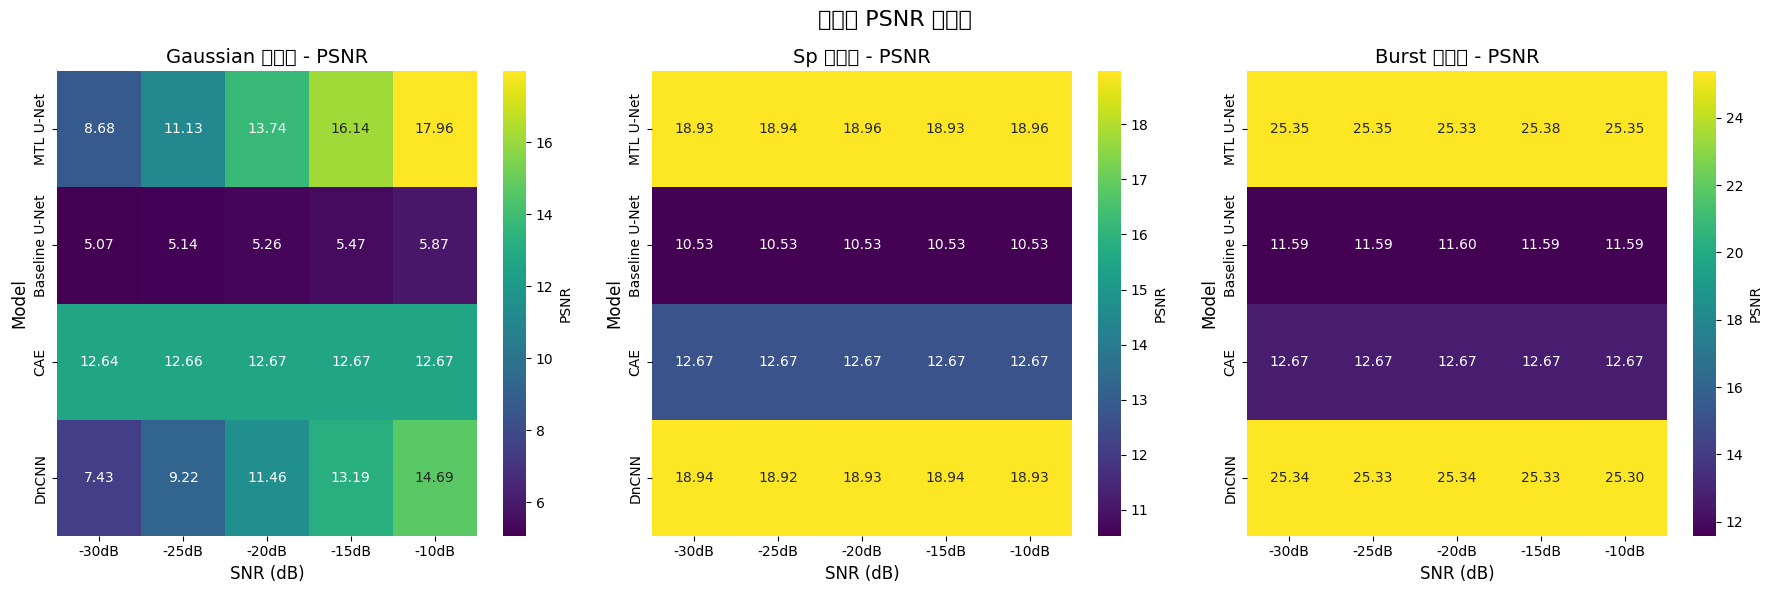

/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51592 (\N{HANGUL SYLLABLE JEU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-package

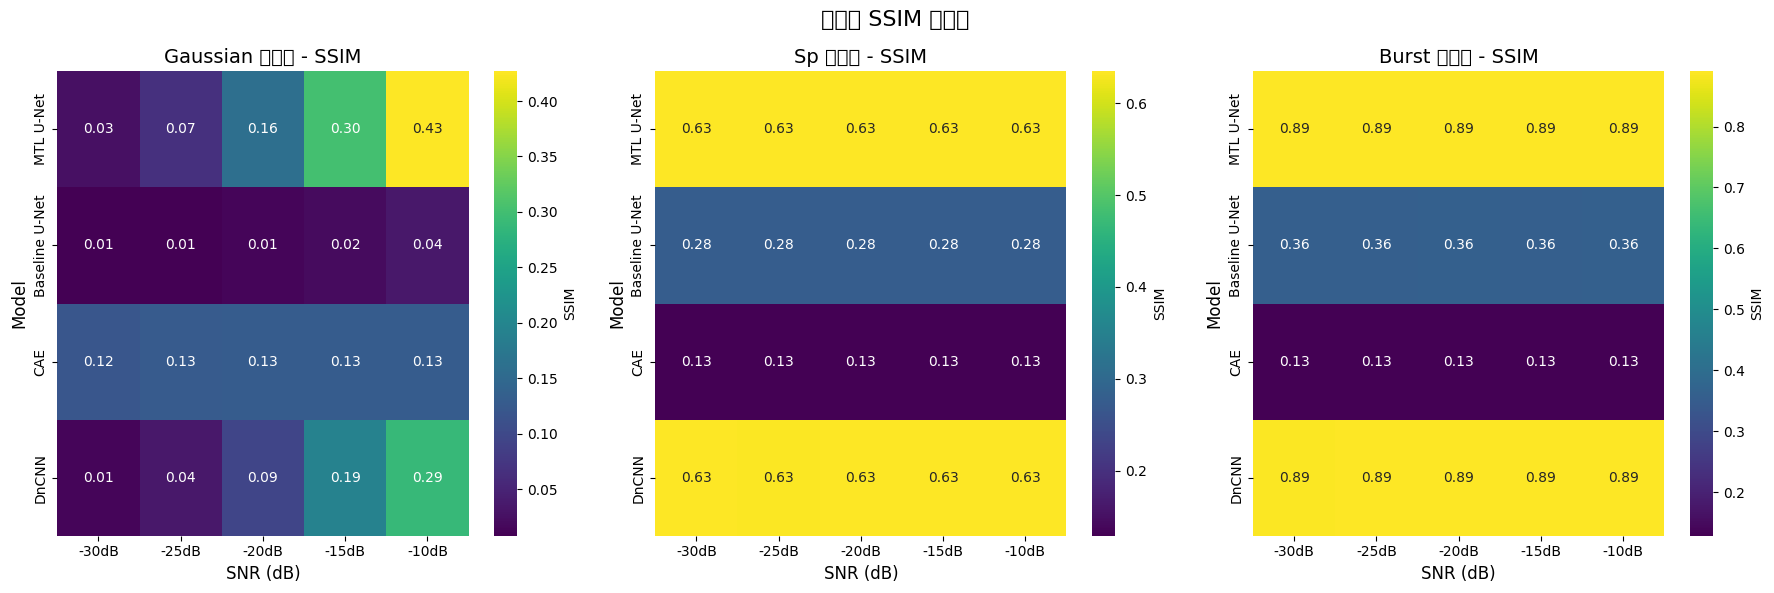

In [ ]:
# Part 12: 상세 분석 및 히트맵
print("=== 상세 분석 및 히트맵 ===")

def create_heatmap(all_results, snr_levels, metric='psnr'):
    """히트맵 생성"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for idx, noise_type in enumerate(['gaussian', 'sp', 'burst']):
        ax = axes[idx]
        
        # 데이터 준비
        heatmap_data = []
        model_names = []
        
        for model_name, model_results in all_results.items():
            model_names.append(model_name)
            row_data = []
            for snr in snr_levels:
                if snr in model_results[noise_type]:
                    if metric == 'psnr':
                        row_data.append(model_results[noise_type][snr]['psnr_mean'])
                    else:  # ssim
                        row_data.append(model_results[noise_type][snr]['ssim_mean'])
                else:
                    row_data.append(0)
            heatmap_data.append(row_data)
        
        # 히트맵 생성
        sns.heatmap(heatmap_data, 
                   xticklabels=[f'{snr}dB' for snr in snr_levels],
                   yticklabels=model_names,
                   annot=True, fmt='.2f', cmap='viridis',
                   ax=ax, cbar_kws={'label': f'{metric.upper()}'})
        
        ax.set_title(f'{noise_type.title()} 노이즈 - {metric.upper()}', fontsize=14)
        ax.set_xlabel('SNR (dB)', fontsize=12)
        ax.set_ylabel('Model', fontsize=12)
    
    plt.suptitle(f'Model Comparison: {metric.upper()} Heatmap', fontsize=16)
    plt.tight_layout()
    plt.show()

# PSNR 히트맵
create_heatmap(all_results, snr_levels, metric='psnr')

# SSIM 히트맵
create_heatmap(all_results, snr_levels, metric='ssim')


In [ ]:
# Part 13: 통계적 분석
print("=== 통계적 분석 ===")

def statistical_analysis(all_results, snr_levels):
    """통계적 분석 수행"""
    
    print("\n=== 전체 성능 요약 ===")
    
    for model_name, model_results in all_results.items():
        print(f"\n{model_name} 모델:")
        
        all_psnr = []
        all_ssim = []
        
        for noise_type, noise_results in model_results.items():
            for snr in snr_levels:
                if snr in noise_results:
                    all_psnr.append(noise_results[snr]['psnr_mean'])
                    all_ssim.append(noise_results[snr]['ssim_mean'])
        
        print(f"  전체 PSNR 평균: {np.mean(all_psnr):.2f} ± {np.std(all_psnr):.2f} dB")
        print(f"  전체 SSIM 평균: {np.mean(all_ssim):.3f} ± {np.std(all_ssim):.3f}")
        print(f"  PSNR 범위: {np.min(all_psnr):.2f} - {np.max(all_psnr):.2f} dB")
        print(f"  SSIM 범위: {np.min(all_ssim):.3f} - {np.max(all_ssim):.3f}")
    
    # 노이즈 타입별 분석
    print("\n=== Noise Type Analysis ===")
    
    for noise_type in ['gaussian', 'sp', 'burst']:
        print(f"\n{noise_type.upper()} Noise:")
        
        model_psnr = []
        model_ssim = []
        
        for model_name, model_results in all_results.items():
            if noise_type in model_results:
                noise_psnr = []
                noise_ssim = []
                
                for snr in snr_levels:
                    if snr in model_results[noise_type]:
                        noise_psnr.append(model_results[noise_type][snr]['psnr_mean'])
                        noise_ssim.append(model_results[noise_type][snr]['ssim_mean'])
                
                model_psnr.append((model_name, np.mean(noise_psnr)))
                model_ssim.append((model_name, np.mean(noise_ssim)))
        
        # PSNR 순위
        model_psnr.sort(key=lambda x: x[1], reverse=True)
        print("  PSNR 순위:")
        for i, (model, psnr) in enumerate(model_psnr, 1):
            print(f"    {i}. {model}: {psnr:.2f} dB")
        
        # SSIM 순위
        model_ssim.sort(key=lambda x: x[1], reverse=True)
        print("  SSIM 순위:")
        for i, (model, ssim) in enumerate(model_ssim, 1):
            print(f"    {i}. {model}: {ssim:.3f}")

# 통계적 분석 실행
statistical_analysis(all_results, snr_levels)


=== 통계적 분석 ===

=== 전체 성능 요약 ===

MTL U-Net 모델:
  전체 PSNR 평균: 19.28 ± 5.20 dB
  전체 SSIM 평균: 0.573 ± 0.299
  PSNR 범위: 8.68 - 25.38 dB
  SSIM 범위: 0.025 - 0.891

Baseline U-Net 모델:
  전체 PSNR 평균: 9.16 ± 2.73 dB
  전체 SSIM 평균: 0.217 ± 0.145
  PSNR 범위: 5.07 - 11.60 dB
  SSIM 범위: 0.008 - 0.358

CAE 모델:
  전체 PSNR 평균: 12.67 ± 0.01 dB
  전체 SSIM 평균: 0.128 ± 0.002
  PSNR 범위: 12.64 - 12.67 dB
  SSIM 범위: 0.120 - 0.129

DnCNN 모델:
  전체 PSNR 평균: 18.49 ± 5.97 dB
  전체 SSIM 평균: 0.549 ± 0.323
  PSNR 범위: 7.43 - 25.34 dB
  SSIM 범위: 0.015 - 0.890

=== 노이즈 타입별 분석 ===

GAUSSIAN 노이즈:
  PSNR 순위:
    1. MTL U-Net: 13.53 dB
    2. CAE: 12.66 dB
    3. DnCNN: 11.20 dB
    4. Baseline U-Net: 5.36 dB
  SSIM 순위:
    1. MTL U-Net: 0.196
    2. CAE: 0.126
    3. DnCNN: 0.125
    4. Baseline U-Net: 0.018

SP 노이즈:
  PSNR 순위:
    1. MTL U-Net: 18.94 dB
    2. DnCNN: 18.93 dB
    3. CAE: 12.67 dB
    4. Baseline U-Net: 10.53 dB
  SSIM 순위:
    1. MTL U-Net: 0.634
    2. DnCNN: 0.633
    3. Baseline U-Net: 0.276
    4. CAE: 0.1

In [14]:
# Part 14: 결과 저장
print("=== 결과 저장 ===")

# 결과를 CSV 파일로 저장
results_df.to_csv('psnr_ssim_comparison_results.csv', index=False)
print("결과가 'psnr_ssim_comparison_results.csv' 파일로 저장되었습니다.")

# 요약 통계 저장
summary_stats = []
for model_name, model_results in all_results.items():
    all_psnr = []
    all_ssim = []
    
    for noise_type, noise_results in model_results.items():
        for snr in snr_levels:
            if snr in noise_results:
                all_psnr.append(noise_results[snr]['psnr_mean'])
                all_ssim.append(noise_results[snr]['ssim_mean'])
    
    summary_stats.append({
        'Model': model_name,
        'PSNR_Mean': np.mean(all_psnr),
        'PSNR_Std': np.std(all_psnr),
        'SSIM_Mean': np.mean(all_ssim),
        'SSIM_Std': np.std(all_ssim)
    })

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv('psnr_ssim_summary.csv', index=False)
print("요약 통계가 'psnr_ssim_summary.csv' 파일로 저장되었습니다.")

print("\n=== 분석 완료 ===")
print("PSNR과 SSIM 비교 분석이 완료되었습니다!")
print("결과 파일들이 저장되었습니다.")


=== 결과 저장 ===
결과가 'psnr_ssim_comparison_results.csv' 파일로 저장되었습니다.
요약 통계가 'psnr_ssim_summary.csv' 파일로 저장되었습니다.

=== 분석 완료 ===
PSNR과 SSIM 비교 분석이 완료되었습니다!
결과 파일들이 저장되었습니다.
